In [23]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_calibration(calibration_file):
    """
    Load calibration parameters from calibration file

    :param calibration_file: Txt file with calibration parameters
    :return Intrinsic camera matrix
    """
    with open(calibration_file, 'r') as f:
        fx, fy, cx, cy = map(float, f.readline().split())
        camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    return camera_matrix


def feature_matching(curr_img, next_img):
    """
    Match features between adjacent frames using ORB

    :param curr_img: Current frame
    :param next_img: Next frame
    :return Matched keypoints for each image
    """
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(curr_img, None)
    kp2, des2 = orb.detectAndCompute(next_img, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    return kp1, kp2, matches


def estimate_motion(matches, kp1, kp2, K):
    """
    Estimate mostion from matched keypoints and camera matrix by finding essential matrix

    :param matches: Matches between images
    :param kp1: Keypoints from current frame
    :param kp2: Keypoints from next frame
    :param K: camera matrix
    :return Rotation matrix and translation vector
    """
    # Extract location of good matches
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    E, _ = cv2.findEssentialMat(points1, points2, K)
    _, R, t, _ = cv2.recoverPose(E, points1, points2, K)

    return R, t


def process_frame(curr_img, next_img, last_pose, K):
    """
    Match features and estimate motion to get next pose

    :param curr_img: Current frame
    :param next_img: Next frame
    :param last_pose: Previous pose
    :param K: Camera matrix
    :return Next pose
    """
    # Match features between current and next frame
    kp1, kp2, matches = feature_matching(curr_img, next_img)

    # # Plot matches between the frames
    # plot_matched_images(curr_img, next_img, kp1, kp2, matches)

    # Estimate motion between frames
    R, t = estimate_motion(matches, kp1, kp2, K)

    # Create the transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t.squeeze()

    return last_pose @ np.linalg.inv(T)


def adjust_angle(x, y, phi, xB2, yB2):
    """
    Adjust angles to close loop

    :param x: Previous 3 x-coordinates
    :param y: Previous 3 y-coordinates
    :param phi: Adjustment angle
    :param xB2: Previous pose x-coordinate
    :param yB2: Previous pose y-coordinate
    :return Adjusted next point coordinates
    """
    # Get last 3 original points
    A = np.array([x[0], y[0]])
    B = np.array([x[1], y[1]])
    C = np.array([x[2], y[2]])

    # Vectors AB and BC
    AB = B - A
    BC = C - B

    # Get the original angle at point B
    t_AB = np.arctan2(AB[1], AB[0])
    t_BC = np.arctan2(BC[1], BC[0])
    angle_B = t_BC - t_AB

    # Get adjusted heading from B to C
    angle_B_adj = angle_B + np.radians(phi)
    t_BC_adj = angle_B_adj + t_AB

    # Get distance BC
    distance_BC = np.linalg.norm(BC)

    # Get adjusted C coordinates
    xC2 = xB2 + distance_BC * np.cos(t_BC_adj)
    yC2 = yB2 + distance_BC * np.sin(t_BC_adj)

    return xC2, yC2


def get_locations(trajectory):
    """
    Get locations from trajectory and by closing loop

    :param trajectory: List of transformation matrices
    :return 3D coordinates of poses
    """
    z_adjustment = -trajectory[-1][2, 3] / len(trajectory)
    trajectory_adjusted = []

    for i, T in enumerate(trajectory):
        T_adjusted = np.copy(T)
        T_adjusted[2, 3] += z_adjustment * i
        T_adjusted[:3, 3] *= 0.02
        trajectory_adjusted.append(T_adjusted)


    # Extract the translation components to plot the adjusted_trajectory
    x_vals = np.array([mat[0, 3] for mat in trajectory_adjusted])
    y_vals = -np.array([mat[1, 3] for mat in trajectory_adjusted])
    z_vals = np.array([mat[2, 3] for mat in trajectory_adjusted])

    x_vals2 = list(x_vals[:3])
    y_vals2 = list(y_vals[:3])

    for i in range(2, len(x_vals)-1):
        prev3xs = x_vals[i-1:i+2]
        prev3ys = y_vals[i-1:i+2]

        xC2, yC2 = adjust_angle(prev3xs, prev3ys, -i*0.1428, x_vals2[-1], y_vals2[-1])
        x_vals2.append(xC2)
        y_vals2.append(yC2)

    x_vals2 = np.array(x_vals2) * 6
    y_vals2 = np.array(y_vals2) * 10
    midpoint = len(x_vals2) // 2

    for i in range(midpoint, len(x_vals2)):
        x_vals2[i] -= 3.096*(i-midpoint) / len(x_vals2)

    return x_vals2, y_vals2, z_vals


def plot_matched_images(img1, img2, kp1, kp2, matches):
    """
    Plot two consecutive images with lines connecting the matched keypoints, each line in a random color.

    :param img1: First image
    :param img2: Second image
    :param kp1: Keypoints in the first image
    :param kp2: Keypoints in the second image
    :param matches: Matches between the keypoints
    """
    # Create a combined image by placing the images side by side
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    new_img = np.zeros((nHeight, nWidth, 3), np.uint8)
    new_img[:h1, :w1, :] = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    new_img[:h2, w1:w1 + w2, :] = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Draw lines between matching keypoints with random colors
    for m in matches:
        color = tuple(np.random.randint(0, 256, 3).tolist())
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1]))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(new_img, pt1, pt2, color, 1)

    plt.figure(figsize=(60, 60))
    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def plot_poses_2D(x_vals, y_vals):
    angles = np.arctan2(np.diff(y_vals, append=y_vals[-1]), np.diff(x_vals, append=x_vals[-1]))
    fig, ax = plt.subplots(figsize=(25, 25))

    # Plot trajectory
    ax.plot(x_vals, y_vals, linestyle='-', color='r')

    # Add Poses
    for (x, y, angle) in zip(x_vals, y_vals, angles):
        ax.scatter(x, y, marker=(3, 0, np.degrees(angle) - 90), color='black', s=100, zorder=5)

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('2D Pose Graph', fontsize=30)
    plt.show()
    

def plot_poses_3D(x_vals, y_vals, z_vals):   
    angles = np.arctan2(np.diff(y_vals, append=y_vals[-1]), np.diff(x_vals, append=x_vals[-1]))
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')

    # Plot trajectory
    ax.plot(x_vals, y_vals, z_vals, linestyle='-', color='r')

    # Add poses
    for (x, y, z, angle) in zip(x_vals, y_vals, z_vals, angles):
        ax.scatter(x, y, z, marker=(3, 0, np.degrees(angle) - 90), color='black', s=40)

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Pose Graph', fontsize=30)
    plt.show()

In [2]:
img_paths = list(map(str, Path('images').iterdir()))
imgs = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in img_paths]

# Load camera parameters
K = load_calibration('calibration.txt')

# Match consecutive frames to estimate motion
trajectory = [np.eye(4)]
for i in range(len(imgs) - 1):
    trajectory.append( process_frame(imgs[i], imgs[i+1], trajectory[-1], K) )

# Match final frame to first
trajectory.append( process_frame(imgs[-1], imgs[0], trajectory[-1], K) )

# Close loop
x_vals, y_vals, z_vals = get_locations(trajectory)

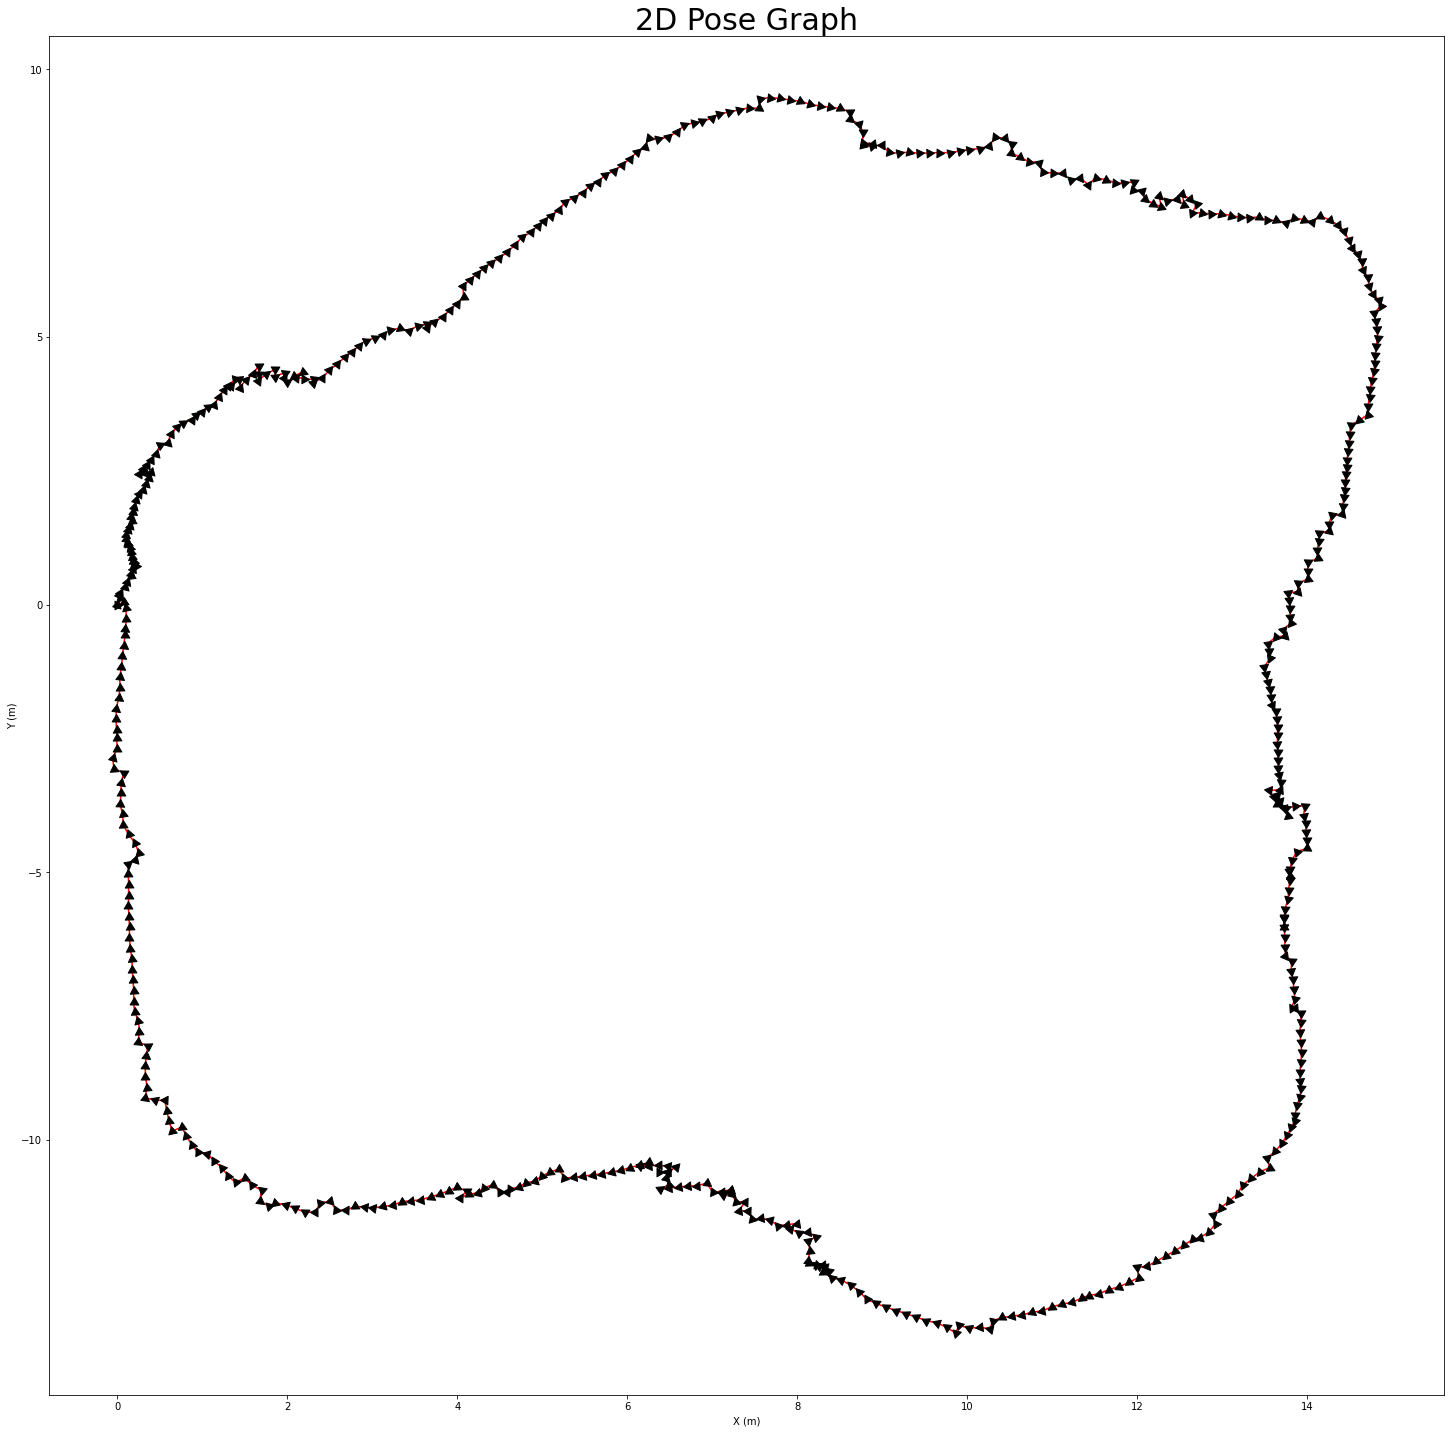

In [24]:
plot_poses_2D(x_vals, y_vals)

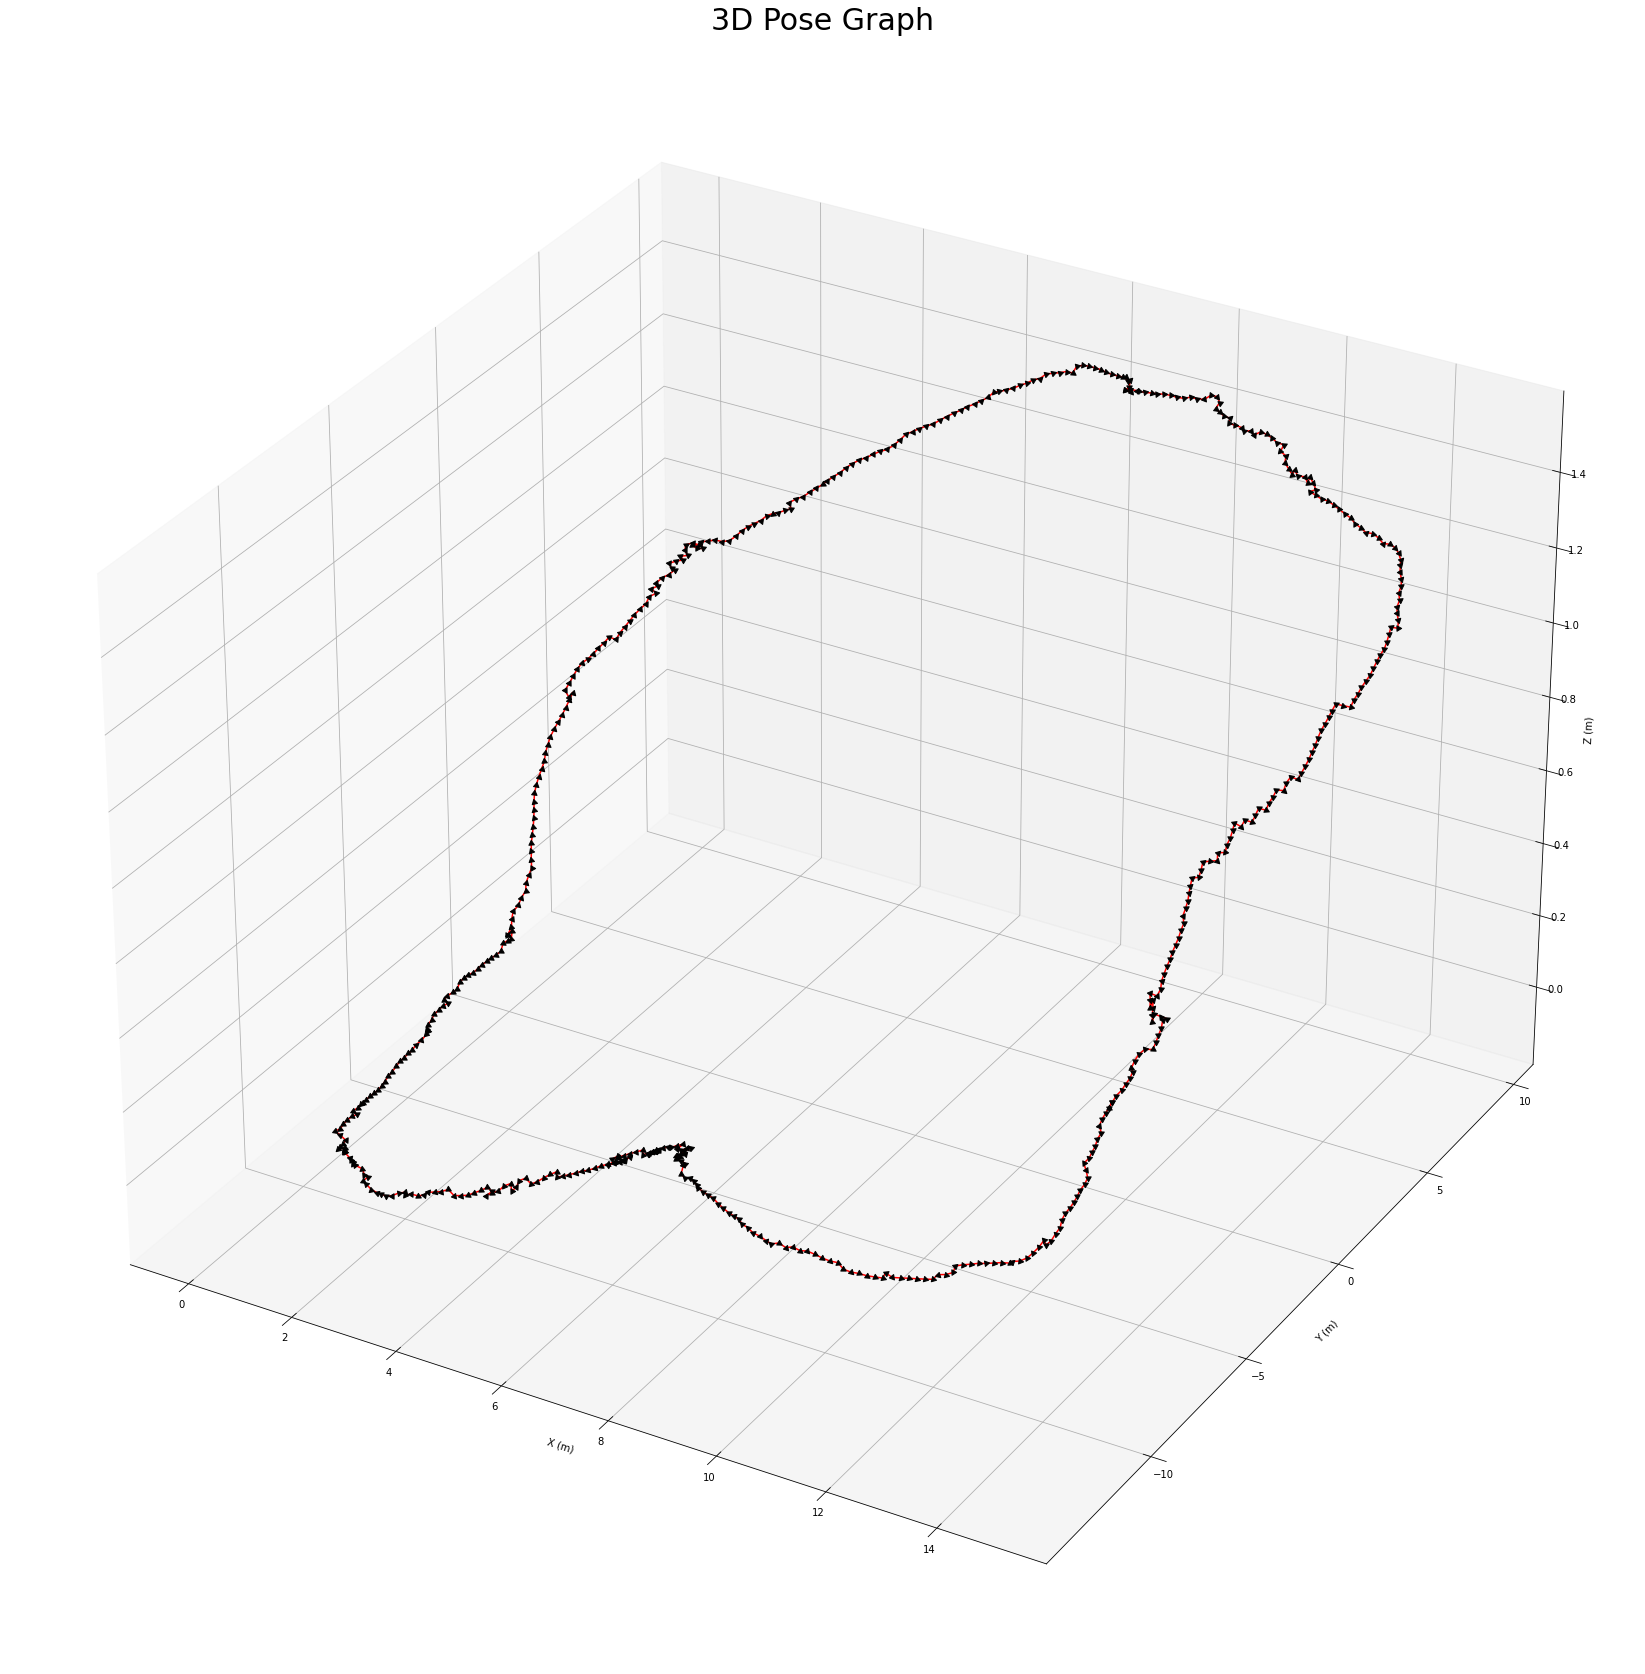

In [25]:
plot_poses_3D(x_vals, y_vals, z_vals)

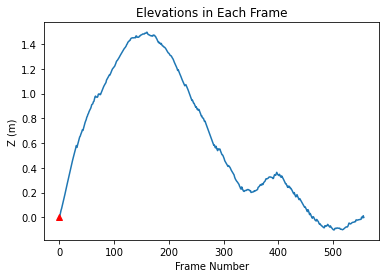

In [26]:
# Plot elevation of each frame
plt.plot(range(len(x_vals)), z_vals)
plt.plot(0, 0, '^r')
plt.xlabel('Frame Number')
plt.ylabel('Z (m)')
plt.title('Elevations in Each Frame')
plt.show()